# Generate a Hex map for the species in the database

The code is based on the example provided by Matilda Stevenson et al. at:
https://labs.ala.org.au/posts/2021-04-14_hex-maps-for-species-occurrence-data/post.html

Load packages

In [2]:
library(ggplot2)
library(tidyr)
library(dplyr)
library(ozmaps)
library(sf)
library(purrr)
library(galah)

Read the email of the galah user for galah config

In [6]:
galah_config(email = readLines("../secrets/galah-email.txt"))

In [8]:
nsw <- st_transform(ozmaps::ozmap_states, 4326) %>% filter(NAME == "New South Wales")

In [11]:
target_occ <- galah_call() %>%
    galah_identify("Brunoniella pumilio") %>%
    galah_apply_profile(ALA) %>%
    galah_geolocate(nsw, type = "bbox") %>%
    atlas_occurrences()

Data returned for bounding box:
xmin = 140.99927 xmax = 153.62987 ymin = -37.50502 ymax = -28.15702
This query will return 1,663 records



Checking queue
Current queue size: 1 inqueue  running .....

In [12]:
target_occ

decimalLatitude,decimalLongitude,eventDate,scientificName,taxonConceptID,recordID,dataResourceName,occurrenceStatus
<dbl>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>
-37.51500,149.6177,1980-10-01 00:00:00,Brunoniella pumilio,https://id.biodiversity.org.au/node/apni/2887339,45e469b6-2ce2-4da2-ac5d-0bbec426938c,Victorian Biodiversity Atlas,PRESENT
-37.49470,149.6602,1995-11-23 00:00:00,Brunoniella pumilio,https://id.biodiversity.org.au/node/apni/2887339,35936864-4c25-45b5-b439-de80e9274218,Victorian Biodiversity Atlas,PRESENT
-37.49430,149.6616,2020-10-23 00:00:00,Brunoniella pumilio,https://id.biodiversity.org.au/node/apni/2887339,c6a0281b-9533-404f-99d9-baeaff875782,Victorian Biodiversity Atlas,PRESENT
-37.49430,149.6617,2015-10-17 00:00:00,Brunoniella pumilio,https://id.biodiversity.org.au/node/apni/2887339,99ecb50d-87df-4bba-b165-d56f771ef636,Victorian Biodiversity Atlas,PRESENT
-37.49430,149.6616,2020-10-23 00:00:00,Brunoniella pumilio,https://id.biodiversity.org.au/node/apni/2887339,8a9eafc8-c474-4fa7-89ef-a26d03b45dcc,Victorian Biodiversity Atlas,PRESENT
-37.49428,149.6616,2021-11-06 00:43:00,Brunoniella pumilio,https://id.biodiversity.org.au/node/apni/2887339,89ef7039-8a4c-440c-8021-55e2a9c31b94,iNaturalist Australia,PRESENT
-37.49417,149.6614,1970-10-24 00:00:00,Brunoniella pumilio,https://id.biodiversity.org.au/node/apni/2887339,be5fd93e-47e5-4bb6-9c3d-4c927323f365,National Herbarium of Victoria (MEL) AVH data,PRESENT
-37.49410,149.6605,2020-10-24 00:00:00,Brunoniella pumilio,https://id.biodiversity.org.au/node/apni/2887339,35a75131-ea51-43f9-b90b-237fd555eb2a,Victorian Biodiversity Atlas,PRESENT
-37.49220,149.6594,1992-05-01 00:00:00,Brunoniella pumilio,https://id.biodiversity.org.au/node/apni/2887339,cf2880b3-244d-4bef-be3b-7bad870291a0,Victorian Biodiversity Atlas,PRESENT


Make grid and select which intersect NSW map

In [13]:
grid_all <- st_make_grid(nsw, 
                         cellsize = 0.5, 
                         what = "polygons", 
                         square = FALSE,
                         flat_topped = TRUE)

keep_hexes <- st_intersects(grid_all, nsw) %>%
  as.data.frame(.) %>%
  pull(row.id)

oz_grid <- grid_all[keep_hexes]


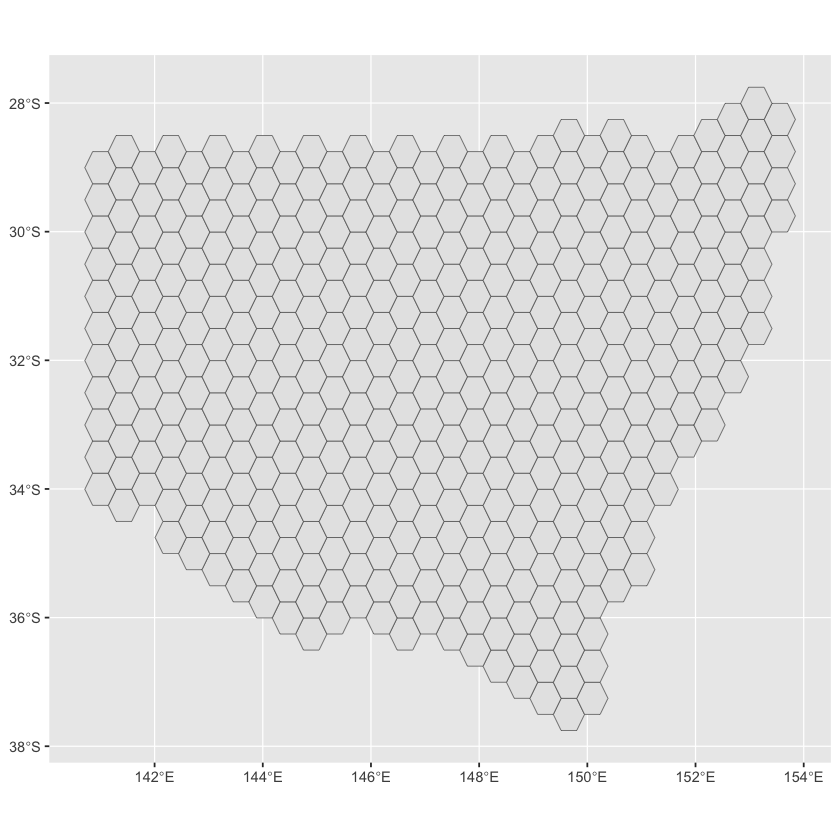

In [14]:
ggplot() + geom_sf(data = oz_grid)

In [15]:
target_points_sf <- target_occ %>% 
  st_as_sf(coords = c("decimalLongitude", "decimalLatitude"), 
  crs = st_crs(4326))

In [16]:
intersect <- st_intersects(target_points_sf, oz_grid)
counts <- as_tibble(table(unlist(intersect)), 
          .name_repair = "unique") %>%
  rename("hex_id" = 1,
         "count" = 2) %>%
  mutate(hex_id = as.integer(hex_id)) %>%
  replace_na(list(count = 0))

New names:
• `` -> `...1`


In [17]:
oz_grid <- oz_grid %>%
  as_tibble() %>%
  mutate(id = row_number()) %>%
  full_join(counts,
            by = join_by(id == hex_id)) %>%
  st_as_sf()

oz_grid |> head()

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



geometry,id,count
<POLYGON [°]>,<int>,<int>
POLYGON ((149.3709 -37.5050...,1,14
POLYGON ((148.9378 -37.2550...,2,NA
POLYGON ((149.8039 -37.2550...,3,5
POLYGON ((148.5048 -37.0050...,4,NA
POLYGON ((149.3709 -37.0050...,5,9
POLYGON ((148.0718 -36.7550...,6,NA


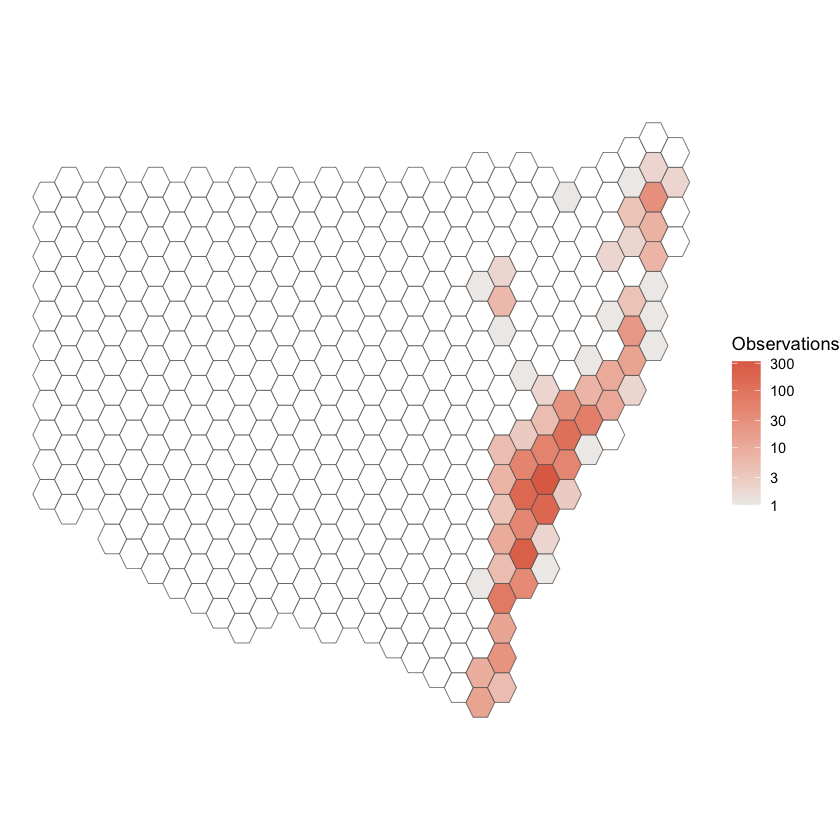

In [19]:
ggplot() +
  geom_sf(data = oz_grid, aes(fill = count), size = .01) +
  scale_fill_gradientn(colours = c("#EEECEA", "#E06E53"), 
                       na.value = "white", 
                       trans = "log10",
                       labels = scales::comma_format(),
                       n.breaks = 6,
                       guide = guide_colourbar(title = "Observations")) +
  theme_void()

In [29]:
oz_grid[1:10,]

geometry,id,count
<POLYGON [°]>,<int>,<int>
POLYGON ((149.3709 -37.5050...,1,14
POLYGON ((148.9378 -37.2550...,2,NA
POLYGON ((149.8039 -37.2550...,3,5
POLYGON ((148.5048 -37.0050...,4,NA
POLYGON ((149.3709 -37.0050...,5,9
POLYGON ((148.0718 -36.7550...,6,NA
POLYGON ((148.9378 -36.7550...,7,NA
POLYGON ((149.8039 -36.7550...,8,27
POLYGON ((147.6388 -36.5050...,9,NA


In [30]:
target_occ <- galah_call() %>%
    galah_identify("Brunoniella pumilio") %>%
    galah_apply_profile(ALA) %>%
    galah_geolocate(st_geometry(oz_grid)[1]) %>%
    atlas_occurrences()

This query will return 17 records



Checking queue
Current queue size: 2 inqueue . running .

In [ ]:
## Number of species per grid

Now, let use species counts per grid, like this example from Dax Kellie: https://labs.ala.org.au/posts/2022-05-17_3d-map/post.html

In [57]:
get_counts <- function(hexagon,spplist="plantae"){
  
    # convert to wkt
    #wkt_string <- st_as_text(oz_grid[[hexagon]]) %>%
    #  sub(")))", "))", .) %>%
    #  sub("POLYGON ", "POLYGON", .)
    wkt_string <- st_geometry(oz_grid %>% slice(hexagon))
    # get counts
    result <- galah_call() |>
      galah_geolocate(wkt_string) |>
      galah_identify(spplist) |>
      galah_filter(decimalLongitude > 110,
                   year >= 2019) |>
      galah_apply_profile(ALA) |>
      atlas_counts(type = "species", # get species counts
                   limit = NULL)
    
    # light formatting to catch errors
    if(is.null(result)){
      tibble(count = NA, id = hexagon)
    }else{
      result$id <- hexagon
      result
    }
  }

In [58]:
get_counts(1)

count,id
<int>,<dbl>
832,1


In [59]:

# download number of species for each polygon
counts_list <- map(seq(1,10), get_counts)


In [60]:

# bind lists to data frame
counts_df <- map_dfr(counts_list, rbind)


In [64]:
oz_grid %>% inner_join(counts_df,by="id")

geometry,id,count.x,count.y
<POLYGON [°]>,<int>,<int>,<int>
POLYGON ((149.3709 -37.5050...,1,14,832
POLYGON ((148.9378 -37.2550...,2,NA,645
POLYGON ((149.8039 -37.2550...,3,5,580
POLYGON ((148.5048 -37.0050...,4,NA,343
POLYGON ((149.3709 -37.0050...,5,9,945
POLYGON ((148.0718 -36.7550...,6,NA,329
POLYGON ((148.9378 -36.7550...,7,NA,486
POLYGON ((149.8039 -36.7550...,8,27,753
POLYGON ((147.6388 -36.5050...,9,NA,195


In [65]:
counts_list <- map(seq_along(oz_grid$id), get_counts)
counts_df <- map_dfr(counts_list, rbind)
oz_df <- oz_grid %>% inner_join(counts_df,by="id")

In [84]:
hex_map <- ggplot() +
  geom_sf(
    data = oz_df,
    mapping = aes(fill = log10(1+count.y)), # log10 + 1 transformed
    alpha = 1,
    color = NA) +
  scale_fill_distiller(name = "Number of species \n(since 1 Jan, 2019)",
                       type = "seq",
                       direction = 1,
                       limits = c(0,4),
                       labels = c("10", "100", "1,000"),
                       palette = "Greens",
                       # edit legend to be horizontal-bottom
                       guide = guide_colorsteps(direction = "horizontal",
                                                label.position = "top",
                                                title.position = "bottom",
                                                title.hjust = 0.5)
                       ) +
  # add map
  geom_sf(data = nsw,
          color = "black",
          fill = NA)+
  # Adjust text and make aesthetic more minimal
  theme(title = element_text(face = "bold"),
        legend.title = element_text(size = 19),
        legend.position = "bottom",
        legend.key.width = unit(28, 'mm'),
        legend.text = element_text(size = 16),
        plot.background = element_rect(fill = 'white', colour = 'white'),
        panel.background = element_rect(fill = 'white', colour = 'white'),
        axis.title = element_blank()
        )


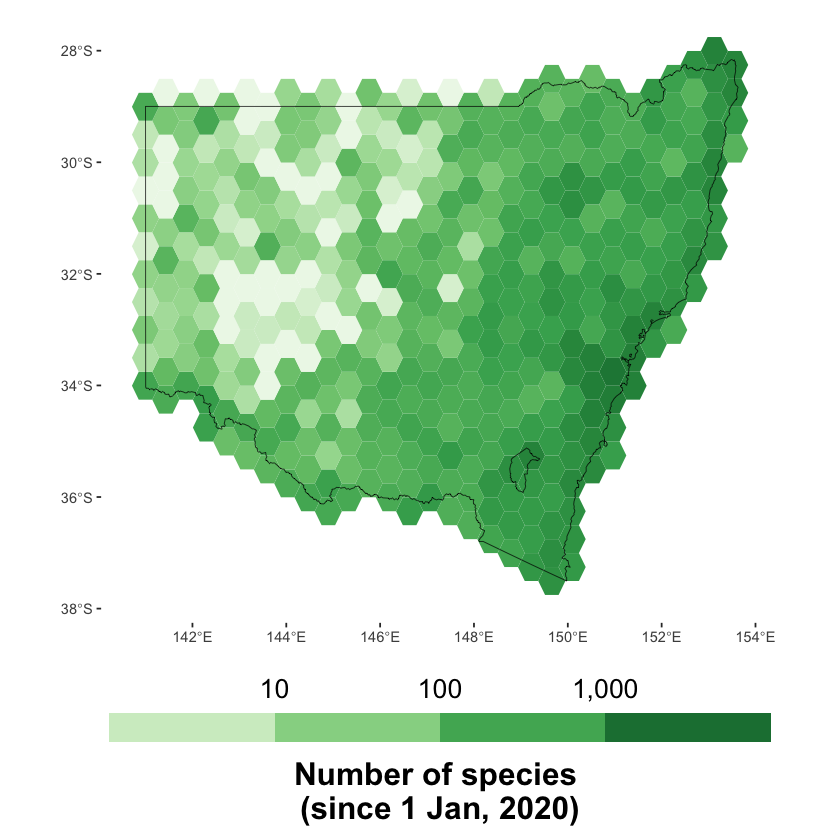

In [85]:

hex_map

In [81]:
max(log10(1+oz_df$count.y))

[1] 3.409933